In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import shap
import os
import math
import xgboost as xgb
import warnings
import joblib

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [2]:

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, 
                           roc_auc_score, 
                           precision_recall_curve,
                           average_precision_score,
                           confusion_matrix,
                           f1_score,
                           roc_curve,
                           recall_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.exceptions import FitFailedWarning



In [3]:
#读取数据
train_data=pd.read_csv("C:\\Users\\lenovo\\毕设-20212133050\\data_train_65.csv")
test_data=pd.read_csv("C:\\Users\\lenovo\\毕设-20212133050\\data_test_65.csv")

In [4]:
train_data.head()

,年龄,性别,GLU,CREA,DBIL,IBIL,UA,AST,ALT,UREA,TBIL,BUN/Scr,阿尔茨海默病
0,81.83,0,6.29,69.1,5.8,10.0,311.0,11.0,7.0,4.92,15.8,18.0,1
1,81.33,1,4.98,92.3,6.2,7.7,482.0,15.0,14.0,9.32,13.9,25.0,1
2,68.75,0,8.18,46.1,2.4,5.1,185.0,36.0,31.0,3.40,7.5,18.0,1
3,68.08,0,5.20,70.1,2.8,7.9,336.0,28.0,21.0,5.64,10.7,20.0,1
4,92.25,1,5.41,137.8,6.2,8.3,515.0,48.0,13.0,7.18,14.5,13.0,1


In [5]:
# 训练集标准化
scaler = StandardScaler()
X_train = train_data[['年龄','性别','GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL','BUN/Scr']]
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=['Age','Gender', 'GLU1', 'CREA1', 'DBIL1', 'IBIL1',
                                                        'UA1', 'AST1', 'ALT1', 'UREA1', 'TBIL1','BUN/Scr1'])
# 验证集标准化
X_test = test_data[['年龄', '性别','GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL','BUN/Scr']]
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=['Age','Gender', 'GLU1', 'CREA1', 'DBIL1', 'IBIL1',
                                                        'UA1', 'AST1', 'ALT1', 'UREA1', 'TBIL1','BUN/Scr1'])


train_data = pd.concat([train_data, X_train_scaled_df], axis=1)
test_data = pd.concat([test_data, X_test_scaled_df], axis=1)

train_data = train_data.drop(['年龄','性别', 'BUN/Scr','GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL'], axis=1)
test_data = test_data.drop(['年龄','性别','BUN/Scr', 'GLU', 'CREA', 'DBIL', 'IBIL', 'UA', 'AST', 'ALT', 'UREA', 'TBIL'], axis=1)

train_data = train_data.assign( status=train_data['阿尔茨海默病'])
test_data = test_data.assign(status=test_data['阿尔茨海默病'])

train_data = train_data.drop(['阿尔茨海默病'], axis=1)
test_data = test_data.drop(['阿尔茨海默病'], axis=1)

# 数据分割
X_train = train_data.drop(['status'], axis=1)
y_train = train_data[['status']]
X_test = test_data.drop(['status'], axis=1)
y_test = test_data[['status']]



In [6]:
# 保存标准化模型
#joblib.dump(scaler, 'scaler_model.pkl')

In [7]:
train_data.head()

,Age,Gender,GLU1,CREA1,DBIL1,IBIL1,UA1,AST1,ALT1,UREA1,TBIL1,BUN/Scr1,status
0,0.480784,-0.748953,-0.097604,-0.300905,0.316433,0.652380,-0.152350,-0.233270,-0.531306,-0.287468,0.513011,-0.049520,1
1,0.411073,1.335197,-0.527889,0.258187,0.386933,0.083473,1.294978,-0.164114,-0.253656,1.124634,0.293125,0.946637,1
2,-1.342861,-0.748953,0.523188,-0.855177,-0.282815,-0.559641,-1.218803,0.198957,0.420638,-0.775285,-0.447546,-0.049520,1
3,-1.436274,-0.748953,-0.455627,-0.276806,-0.212315,0.132943,0.059247,0.060644,0.023995,-0.056397,-0.077211,0.235096,1
4,1.933566,1.335197,-0.386650,1.354682,0.386933,0.231883,1.574287,0.406426,-0.293320,0.437839,0.362562,-0.761062,1


In [8]:
test_data.head()

,Age,Gender,GLU1,CREA1,DBIL1,IBIL1,UA1,AST1,ALT1,UREA1,TBIL1,BUN/Scr1,status
0,0.899051,-0.748953,-0.741389,-0.703355,-0.036066,-0.040203,-1.210339,-0.146825,-0.491642,-0.608400,-0.042492,0.092788,1
1,-0.517480,1.335197,-0.202712,0.258187,0.704182,1.493374,0.084639,-0.060380,0.142988,0.482770,1.161098,0.235096,1
2,0.155930,1.335197,-0.166581,-0.100885,0.298808,0.380294,1.032597,-0.043090,0.222316,0.607933,0.374135,0.946637,1
3,0.376217,1.335197,-0.504896,1.410109,0.175434,0.058737,0.626329,-0.025801,-0.570970,2.440457,0.142676,0.804329,1
4,0.981311,-0.748953,-0.452343,-0.700945,0.210684,0.355559,0.228526,-0.077669,-0.015670,-1.128311,0.304697,-1.045678,1


In [9]:
# 将数据写出到csv文档
#train_data.to_csv('train_data_py.csv', index=False)
#test_data.to_csv('test_data_py.csv', index=False)

In [10]:
#print(train_data.isnull().any())

In [11]:
#print(train_data.isnull().any())

In [12]:
X_train

,Age,Gender,GLU1,CREA1,DBIL1,IBIL1,UA1,AST1,ALT1,UREA1,TBIL1,BUN/Scr1
0,0.480784,-0.748953,-0.097604,-0.300905,0.316433,0.652380,-0.152350,-0.233270,-0.531306,-0.287468,0.513011,-0.049520
1,0.411073,1.335197,-0.527889,0.258187,0.386933,0.083473,1.294978,-0.164114,-0.253656,1.124634,0.293125,0.946637
2,-1.342861,-0.748953,0.523188,-0.855177,-0.282815,-0.559641,-1.218803,0.198957,0.420638,-0.775285,-0.447546,-0.049520
3,-1.436274,-0.748953,-0.455627,-0.276806,-0.212315,0.132943,0.059247,0.060644,0.023995,-0.056397,-0.077211,0.235096
4,1.933566,1.335197,-0.386650,1.354682,0.386933,0.231883,1.574287,0.406426,-0.293320,0.437839,0.362562,-0.761062
...,...,...,...,...,...,...,...,...,...,...,...,...
2544,-1.192285,-0.748953,-0.160012,-0.544303,-0.194690,-0.287554,-0.160814,-0.112247,-0.213991,-0.496074,-0.262378,-0.049520
2545,1.875008,1.335197,-0.583727,0.007560,2.255179,0.503970,-2.099049,0.026066,1.293253,-0.107746,1.716600,-0.191829
2546,-0.691758,-0.748953,-0.432635,-0.346693,-0.088941,0.231883,-0.897174,-0.008512,-0.134663,-0.120583,0.050092,0.235096
2547,-0.680605,-0.748953,-0.268404,-0.300905,-0.494315,-0.930667,0.050783,-0.094958,0.103323,-0.152676,-0.760016,0.092788


In [13]:
X_test

,Age,Gender,GLU1,CREA1,DBIL1,IBIL1,UA1,AST1,ALT1,UREA1,TBIL1,BUN/Scr1
0,0.899051,-0.748953,-0.741389,-0.703355,-0.036066,-0.040203,-1.210339,-0.146825,-0.491642,-0.608400,-0.042492,0.092788
1,-0.517480,1.335197,-0.202712,0.258187,0.704182,1.493374,0.084639,-0.060380,0.142988,0.482770,1.161098,0.235096
2,0.155930,1.335197,-0.166581,-0.100885,0.298808,0.380294,1.032597,-0.043090,0.222316,0.607933,0.374135,0.946637
3,0.376217,1.335197,-0.504896,1.410109,0.175434,0.058737,0.626329,-0.025801,-0.570970,2.440457,0.142676,0.804329
4,0.981311,-0.748953,-0.452343,-0.700945,0.210684,0.355559,0.228526,-0.077669,-0.015670,-1.128311,0.304697,-1.045678
...,...,...,...,...,...,...,...,...,...,...,...,...
633,1.236454,-0.748953,1.304926,-0.103295,-0.194690,0.132943,-0.211598,0.129800,0.737953,0.017418,-0.065638,0.092788
634,-1.749974,-0.748953,-0.284827,0.041298,-0.229940,-0.139144,0.160814,-0.198692,-0.213991,-0.871565,-0.216086,-1.330295
635,-1.482283,-0.748953,-0.376796,-0.655157,-0.036066,-0.312289,-0.016928,-0.008512,-0.094998,-0.817006,-0.169794,-0.476445
636,-0.227482,1.335197,0.963326,0.369041,0.422183,1.740725,1.015669,-0.181403,-0.412313,0.463514,1.091660,0.092788


In [14]:
print("训练数据维度验证")
print("原始特征数:", X_train.shape[1])  
print("标准化器期望特征数:", scaler.n_features_in_)  
print("特征列表:", list(X_train.columns)) 

训练数据维度验证
原始特征数: 12
标准化器期望特征数: 12
特征列表: ['Age', 'Gender', 'GLU1', 'CREA1', 'DBIL1', 'IBIL1', 'UA1', 'AST1', 'ALT1', 'UREA1', 'TBIL1', 'BUN/Scr1']


In [15]:
print("训练集分布:", Counter(train_data['status']))
print("测试集分布:", Counter(test_data['status']))

训练集分布: Counter({1: 2328, 0: 221})
测试集分布: Counter({1: 583, 0: 55})


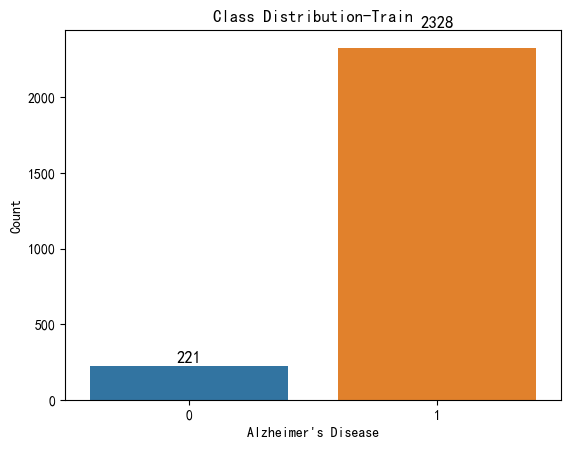

In [16]:
# 绘制train-条形图
ax = sns.countplot(data=train_data, x="status")
plt.xlabel("Alzheimer's Disease")
plt.ylabel("Count")
plt.title("Class Distribution-Train")

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x = p.get_x() + p.get_width() / 2,  
        y = height + 0.05 * height,         
        s = f'{height:.0f}',                
        ha = 'center',                      
        va = 'bottom',                      
        fontsize=12
    )

plt.show()

从上述图表，我们发现无论是训练集上存在样本分布不平衡问题。由于阿尔默茨海默症是老年人常发生的病症，因此当数据集限定年龄>65岁后，患者样本数多于正常样本。我们需要对模型进行过采样或者是欠采样来平衡数据集。

In [17]:
print("原始标签分布:", train_data['status'].value_counts())

原始标签分布: 1    2328
0     221
Name: status, dtype: int64


In [18]:
# 触发此错误时，说明你的标签列只有一个类别（比如全是1或全是0）
print(y_train.value_counts())

status
1         2328
0          221
dtype: int64


In [19]:
#对数据集进行过采样
X_train = train_data.iloc[:,np.r_[0:12]]
y_train = train_data['status']
print("原始训练集类别分布:", np.bincount(y_train))

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
print("平衡后训练集类别分布:", np.bincount(y_train_balanced))

原始训练集类别分布: [ 221 2328]
平衡后训练集类别分布: [2328 2328]


In [20]:
#保存平衡后的数据集
'''balanced_data = pd.concat([
    X_train_balanced, 
    pd.Series(y_train_balanced, name="阿尔茨海默病")  
], axis=1)

balanced_data.to_csv("data_balanced.csv", index=False)'''

'balanced_data = pd.concat([\n    X_train_balanced, \n    pd.Series(y_train_balanced, name="阿尔茨海默病")  \n], axis=1)\n\nbalanced_data.to_csv("data_balanced.csv", index=False)'

In [21]:
#逻辑回归模型---LR model 1
LR_model = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000,           
    random_state=42
)
LR_model.fit(X_train_balanced, y_train_balanced)
LR_y_pred = LR_model.predict(X_test)
LR_y_proba = LR_model.predict_proba(X_test)[:, 1]

print("\n逻辑回归 AUC-ROC:", roc_auc_score(y_test, LR_y_proba))
print("逻辑回归分类报告:\n", classification_report(y_test, LR_y_pred))



逻辑回归 AUC-ROC: 0.8485576173397786
逻辑回归分类报告:
               precision    recall  f1-score   support

           0       0.21      0.78      0.33        55
           1       0.97      0.73      0.83       583

    accuracy                           0.73       638
   macro avg       0.59      0.75      0.58       638
weighted avg       0.91      0.73      0.79       638



In [22]:
# SVM model 2
SVM_model = SVC(
    class_weight='balanced',  
    probability=True,         
    kernel='rbf',             
    random_state=42
)
SVM_model.fit(X_train_balanced, y_train_balanced)

y_pred_SVM = SVM_model.predict(X_test)
y_proba_SVM = SVM_model.predict_proba(X_test)[:, 1]

print("\nSVM AUC-ROC:", roc_auc_score(y_test, y_proba_SVM))
print("SVM分类报告:\n", classification_report(y_test, y_pred_SVM))



SVM AUC-ROC: 0.8288164665523157
SVM分类报告:
               precision    recall  f1-score   support

           0       0.30      0.73      0.42        55
           1       0.97      0.84      0.90       583

    accuracy                           0.83       638
   macro avg       0.63      0.78      0.66       638
weighted avg       0.91      0.83      0.86       638



In [23]:
#DecisionTree model 3
param_grid = {
    'max_depth': [3, 5, 7],  # 树的深度
    'min_samples_split': [5, 7, 10],  # 每个节点分裂所需的最小样本数
    'min_samples_leaf': [2, 4, 6],  # 每个叶节点所需的最小样本数
    'max_features': ['sqrt', 'log2', None],  # 每个分裂考虑的特征数
    'ccp_alpha': [0.0, 0.1, 0.2]  # 成本复杂度剪枝参数
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 使用交叉验证
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)
dt_model = grid_search.best_estimator_

# 使用交叉验证来评估模型性能
scores = cross_val_score(dt_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_dt = dt_model.predict(X_test)

print("\n决策树分类报告:\n", classification_report(y_test, y_pred_dt))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Cross-validation scores: [0.89000534 0.88926577 0.92549033 0.90332503 0.91060963]
Mean cross-validation score: 0.9037392196324052

决策树分类报告:
               precision    recall  f1-score   support

           0       0.25      0.67      0.37        55
           1       0.96      0.81      0.88       583

    accuracy                           0.80       638
   macro avg       0.61      0.74      0.63       638
weighted avg       0.90      0.80      0.84       638



In [24]:
#RF model 4

param_grid = {
    'n_estimators': [30, 50, 100],  # 树的数量
    'max_depth': [3, 5, 7],         # 树的深度
    'min_samples_split': [3, 5, 7], # 每个节点分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 每个叶节点所需的最小样本数
    'max_features': ['sqrt', 'log2', None]  # 每个分裂考虑的特征数
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # 使用交叉验证
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

RF = grid_search.best_estimator_

# 使用早停法来防止过拟合

early_stopping_rounds = 10
eval_set = [(X_test, y_test)]  

# 自定义训练循环以实现早停法

best_score = 0
best_round = 0

# 训练模型并实现早停法
for i in range(RF.n_estimators):
    RF.n_estimators = i + 1
    RF.fit(X_train_balanced, y_train_balanced)
    val_score = RF.score(X_test, y_test)
    
    if val_score > best_score:
        best_score = val_score
        best_round = i + 1
    
    elif i - best_round >= early_stopping_rounds:
        break


RF.n_estimators = best_round
RF.fit(X_train_balanced, y_train_balanced)

# 使用交叉验证来评估模型性能
scores = cross_val_score(RF, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_RF = RF.predict(X_test)
y_proba_RF = RF.predict_proba(X_test)[:, 1]

# 评估
print("AUC-ROC:", roc_auc_score(y_test, y_proba_RF)) 
print("\n分类报告（反映真实场景）:\n", classification_report(y_test, y_pred_RF, zero_division=0))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Cross-validation scores: [0.95503233 0.94851631 0.96697356 0.9680396  0.96384697]
Mean cross-validation score: 0.9604817526749019
AUC-ROC: 0.888616871978793

分类报告（反映真实场景）:
               precision    recall  f1-score   support

           0       0.35      0.73      0.47        55
           1       0.97      0.87      0.92       583

    accuracy                           0.86       638
   macro avg       0.66      0.80      0.69       638
weighted avg       0.92      0.86      0.88       638



In [25]:
# AdaBoost model 5


adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # 基学习器，使用较浅的决策树
    n_estimators=100,                              # 增加估计器数量，但不要过大
    learning_rate=0.1,                           # 降低学习率，减少过拟合风险
    random_state=42
)

# 使用早停法来防止过拟合
# 定义早停法的参数
early_stopping_rounds = 15
eval_set = [(X_test, y_test)]  # 验证集

# 自定义训练循环以实现早停法
# 初始化变量
best_score = 0
best_round = 0

# 训练模型并实现早停法
for i in range(adaboost.n_estimators):
    # 设置当前估计器数量
    adaboost.n_estimators = i + 1
    # 训练模型
    adaboost.fit(X_train_balanced, y_train_balanced)
    # 在验证集上评估性能
    val_score = adaboost.score(X_test, y_test)
    # 更新最佳分数和轮数
    if val_score > best_score:
        best_score = val_score
        best_round = i + 1
    # 如果连续多轮没有提升，则停止训练
    elif i - best_round >= early_stopping_rounds:
        break

# 使用最佳轮数重新训练模型
adaboost.n_estimators = best_round
adaboost.fit(X_train_balanced, y_train_balanced)

# 使用交叉验证来评估模型性能
scores = cross_val_score(adaboost, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred = adaboost.predict(X_test)

print("分类报告：")
print(classification_report(y_test, y_pred))

Cross-validation scores: [0.85759086 0.82133693 0.87180304 0.84356915 0.84157783]
Mean cross-validation score: 0.8471755620111165
分类报告：
              precision    recall  f1-score   support

           0       0.18      0.62      0.28        55
           1       0.95      0.74      0.83       583

    accuracy                           0.73       638
   macro avg       0.57      0.68      0.56       638
weighted avg       0.89      0.73      0.79       638



In [26]:
# GBDT（梯度提升树） model 6

# 梯度提升树分类器
gb_model = GradientBoostingClassifier(
    n_estimators=50,                # 树的数量，增加树的数量可以提高模型性能，但可能导致过拟合，需要调整
    max_depth=2,                     # 树的深度，限制树的深度可以减少过拟合
    learning_rate=0.05,               # 学习率，降低学习率可以减少过拟合
    min_samples_split=5,             # 每个节点分裂所需的最小样本数，增加该值可以减少过拟合
    min_samples_leaf=2,              # 每个叶节点所需的最小样本数，增加该值可以减少过拟合
    max_features='sqrt',             # 每个分裂考虑的特征数，减少该值可以减少过拟合
    subsample=0.5,                   # 训练每棵树时使用的数据比例，减少该值可以减少过拟合
    random_state=42
)

# 使用早停法来防止过拟合
gb_model.fit(
    X_train_balanced, 
    y_train_balanced
)

# 使用交叉验证来评估模型性能
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gb_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", np.mean(scores))

y_pred_gb = gb_model.predict(X_test)

print("\n梯度提升树分类报告:\n", classification_report(y_test, y_pred_gb))

Cross-validation scores: [0.91578635 0.89765794 0.93324796 0.92734552 0.91925562]
Mean cross-validation score: 0.9186586769691557

梯度提升树分类报告:
               precision    recall  f1-score   support

           0       0.29      0.75      0.41        55
           1       0.97      0.83      0.89       583

    accuracy                           0.82       638
   macro avg       0.63      0.79      0.65       638
weighted avg       0.91      0.82      0.85       638



In [27]:
# XGBoost model 7

scale_pos_weight = 1  

# XGBoost参数
params_xgb = {
    'learning_rate': 0.01,            # 学习率，降低学习率可以减少过拟合
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'verbosity': 1,
    'seed': 42,
    'nthread': -1,
    'colsample_bytree': 0.5,          # 特征子采样比例，降低过拟合风险
    'subsample': 0.6,                 # 样本子采样比例，降低过拟合风险
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,  # 根据实际情况调整
    'gamma': 0.1,                     # 分裂所需的最小增益，增大gamma可以减少过拟合
    'min_child_weight': 5,            # 增大最小叶节点权重，减少过拟合风险
    'reg_alpha': 0.1,                 # L1正则化系数，增加正则化强度
    'reg_lambda': 1.0                 # L2正则化系数，增加正则化强度
}

# 参数网格
param_grid = {
    'n_estimators': [100, 200],       # 树的数量
    'max_depth': [3, 5],              # 树的深度，限制树的深度可以减少过拟合
    'learning_rate': [0.01]           # 学习率
}

# 网格搜索
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**params_xgb),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,                             # 使用交叉验证来评估模型性能
    n_jobs=-1,
    verbose=1
)

# 使用早停法来防止过拟合
grid_search.fit(
    X_train_balanced, 
    y_train_balanced,
    eval_set=[(X_test, y_test)]
)

XGB_model = grid_search.best_estimator_

y_pred_xgb = XGB_model.predict(X_test)
y_proba_xgb = XGB_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[0]	validation_0-logloss:0.68885
[1]	validation_0-logloss:0.68473
[2]	validation_0-logloss:0.68144
[3]	validation_0-logloss:0.67728
[4]	validation_0-logloss:0.67312
[5]	validation_0-logloss:0.66957
[6]	validation_0-logloss:0.66560
[7]	validation_0-logloss:0.66211
[8]	validation_0-logloss:0.65935
[9]	validation_0-logloss:0.65646
[10]	validation_0-logloss:0.65294
[11]	validation_0-logloss:0.64988
[12]	validation_0-logloss:0.64616
[13]	validation_0-logloss:0.64236
[14]	validation_0-logloss:0.63965
[15]	validation_0-logloss:0.63645
[16]	validation_0-logloss:0.63297
[17]	validation_0-logloss:0.62934
[18]	validation_0-logloss:0.62555
[19]	validation_0-logloss:0.62256
[20]	validation_0-logloss:0.61901
[21]	validation_0-logloss:0.61629
[22]	validation_0-logloss:0.61409
[23]	validation_0-logloss:0.61148
[24]	validation_0-logloss:0.60947
[25]	validation_0-logloss:0.60716
[26]	validation_0-logloss:0.60490
[27]	validation_0-logloss:0.6024

In [36]:
# 绘制所有模型AUC-ROC曲线
roc_curves = {
    "Logistic Regression": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "SVM": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
   
    "Decision Tree": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "Random Forest": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    "GBDT": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
    
    "AdaBoost": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    },
   
    "XGBoost": {
        "train": {"fpr": None, "tpr": None, "auc": None},
        "test": {"fpr": None, "tpr": None, "auc": None}
    }
}



In [42]:

models = {
    "Logistic Regression": LR_model,
    "SVM": SVM_model,
    "Decision Tree": dt_model,
    "Random Forest": RF,
    "GBDT": gb_model,
    "AdaBoost": adaboost,
    "XGBoost": XGB_model
}

ROC Curves Data:
Logistic Regression:
  Train AUC: 0.86
  Test AUC: 0.85
SVM:
  Train AUC: 0.95
  Test AUC: 0.83
Decision Tree:
  Train AUC: 0.93
  Test AUC: 0.82
Random Forest:
  Train AUC: 0.97
  Test AUC: 0.89
GBDT:
  Train AUC: 0.92
  Test AUC: 0.88
AdaBoost:
  Train AUC: 0.85
  Test AUC: 0.80
XGBoost:
  Train AUC: 0.99
  Test AUC: 0.88
Training Set ROC Curves:
  Number of lines: 8


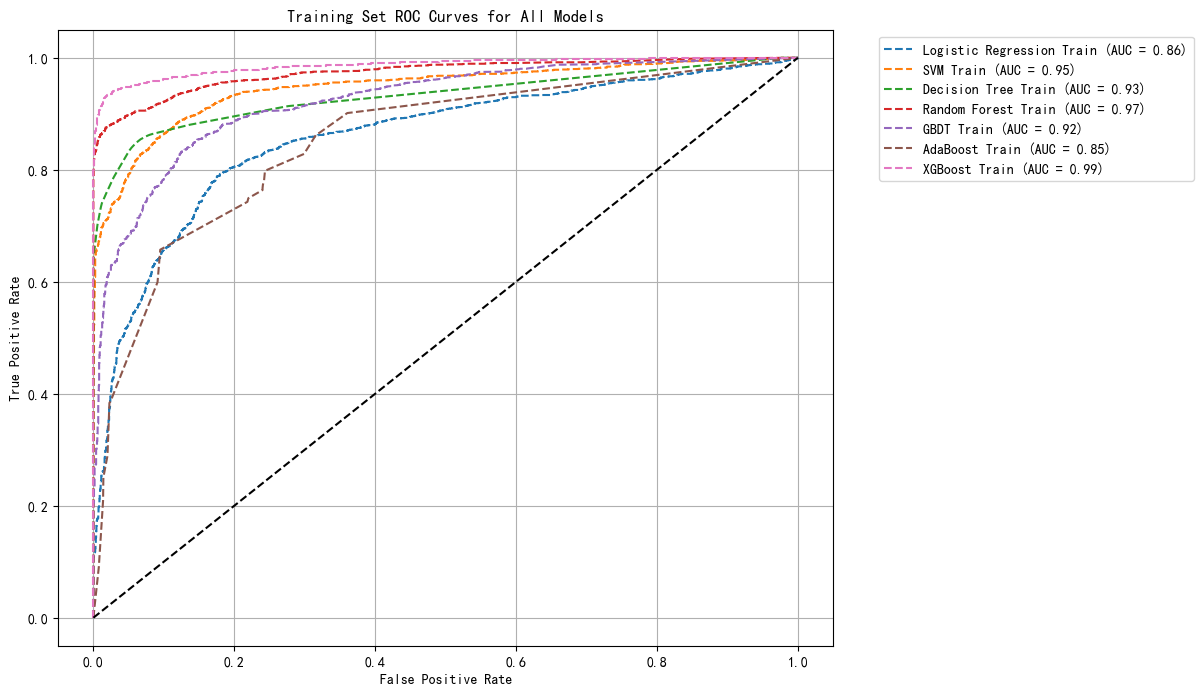

Testing Set ROC Curves:
  Number of lines: 8


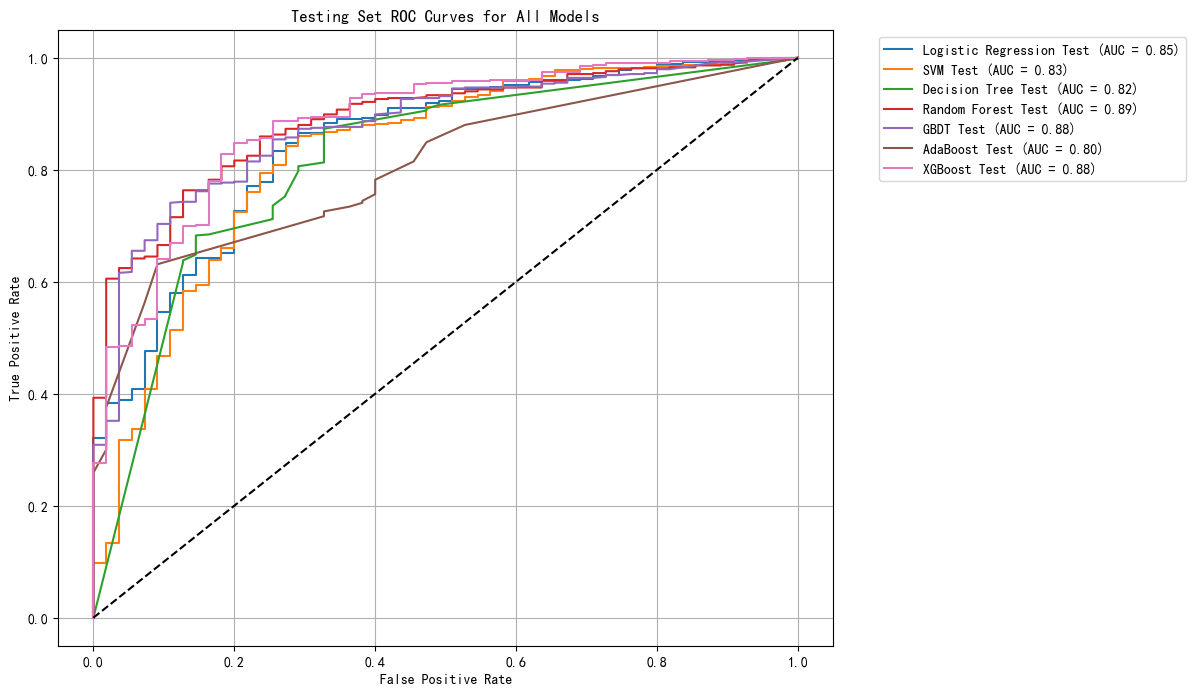

In [43]:
#绘制AUC-ROC曲线图
for name, model in models.items():
    
    train_proba = model.predict_proba(X_train_balanced)[:, 1]
    train_fpr, train_tpr, _ = roc_curve(y_train_balanced, train_proba)
    train_auc = roc_auc_score(y_train_balanced, train_proba)
    

    test_proba = model.predict_proba(X_test)[:, 1]
    test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    roc_curves[name]["train"]["fpr"] = train_fpr
    roc_curves[name]["train"]["tpr"] = train_tpr
    roc_curves[name]["train"]["auc"] = train_auc
    
    roc_curves[name]["test"]["fpr"] = test_fpr
    roc_curves[name]["test"]["tpr"] = test_tpr
    roc_curves[name]["test"]["auc"] = test_auc


print("ROC Curves Data:")
for name, curves in roc_curves.items():
    print(f"{name}:")
    print(f"  Train AUC: {curves['train']['auc']:.2f}")
    print(f"  Test AUC: {curves['test']['auc']:.2f}")

plt.figure(figsize=(10, 8))
for name, curves in roc_curves.items():
    plt.plot(curves["train"]["fpr"], curves["train"]["tpr"], linestyle='--', label=f'{name} Train (AUC = {curves["train"]["auc"]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Set ROC Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid(True)
print("Training Set ROC Curves:")
print("  Number of lines:", len(plt.gca().lines))


#保存
#save_path ='C:\\Users\\lenovo\\毕设-20212133050\\roc_curves\\training_roc_curves.png'
#os.makedirs(os.path.dirname(save_path), exist_ok=True)
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 8))
for name, curves in roc_curves.items():
    plt.plot(curves["test"]["fpr"], curves["test"]["tpr"], label=f'{name} Test (AUC = {curves["test"]["auc"]:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Set ROC Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 调整图例位置
plt.grid(True)
print("Testing Set ROC Curves:")
print("  Number of lines:", len(plt.gca().lines))


#save_path ='C:\\Users\\lenovo\\毕设-20212133050\\roc_curves\\testing_roc_curves.png'
#os.makedirs(os.path.dirname(save_path), exist_ok=True)
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [44]:
#绘制所有模型的混淆矩阵
save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\confusion_matrices1'
os.makedirs(save_dir, exist_ok=True)
for name, model in models.items():
    
    train_pred = model.predict(X_train_balanced)
    cm_train = confusion_matrix(y_train_balanced, train_pred)
    
    
    test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, test_pred)
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp.plot(ax=axes[0], cmap='Blues')
    disp.ax_.set_title(f"{name}\nTrain Confusion Matrix")
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp.plot(ax=axes[1], cmap='Blues')
    disp.ax_.set_title(f"{name}\nTest Confusion Matrix")
    plt.tight_layout()
    
    #save_path = os.path.join(save_dir, f"{name}_confusion_matrices.png")
    #plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

print("所有模型的混淆矩阵已保存到指定路径。")

所有模型的混淆矩阵已保存到指定路径。


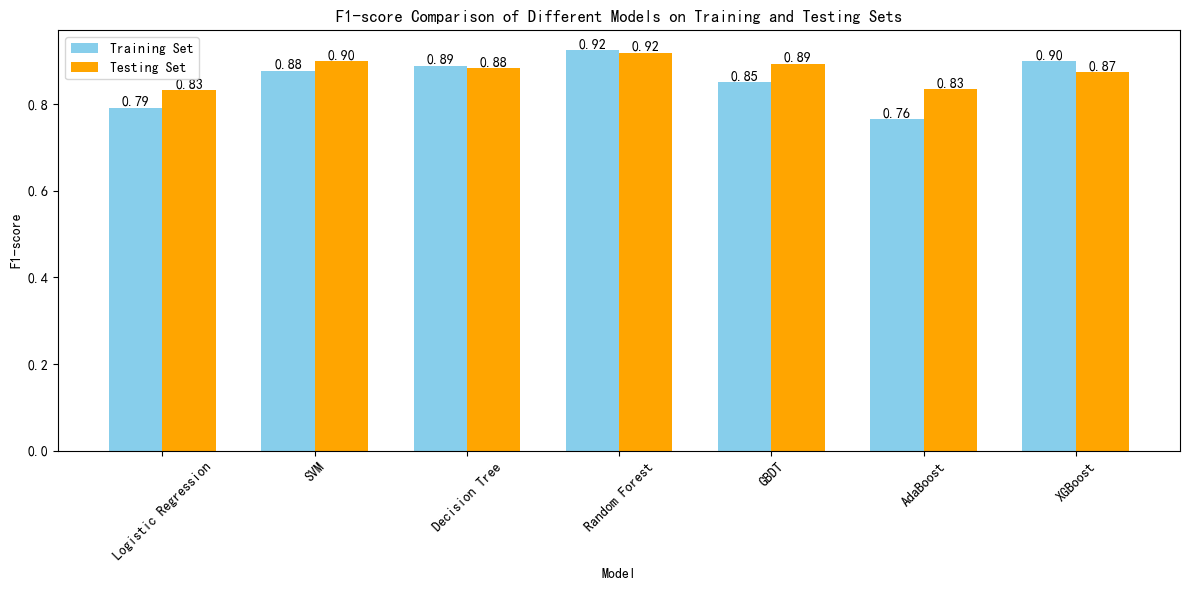

训练集和测试集的 F1-score 柱状图已保存到指定路径。


In [45]:
# 计算训练集和测试集的 F1 值-绘制柱形图
train_f1_scores = {}
test_f1_scores = {}

for name, model in models.items():
    train_pred = model.predict(X_train_balanced)
    train_f1 = f1_score(y_train_balanced, train_pred)
    train_f1_scores[name] = train_f1
    
    
    test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, test_pred)
    test_f1_scores[name] = test_f1

    
plt.figure(figsize=(12, 6))


models = list(train_f1_scores.keys())
train_values = list(train_f1_scores.values())
test_values = list(test_f1_scores.values())


x = np.arange(len(models))  
width = 0.35  

bars1 = plt.bar(x - width/2, train_values, width, label='Training Set', color='skyblue')


bars2 = plt.bar(x + width/2, test_values, width, label='Testing Set', color='orange')


for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')


plt.xlabel('Model')
plt.ylabel('F1-score')
plt.title('F1-score Comparison of Different Models on Training and Testing Sets')
plt.xticks(x, models, rotation=45)
plt.legend()


plt.tight_layout()

# 保存图片
#save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\confusion_matrices1'
#os.makedirs(save_dir, exist_ok=True)
#save_path = os.path.join(save_dir, 'combined_f1_score_bar_chart.png')
#plt.savefig(save_path, dpi=300, bbox_inches='tight')


plt.show()

print("训练集和测试集的 F1-score 柱状图已保存到指定路径。")

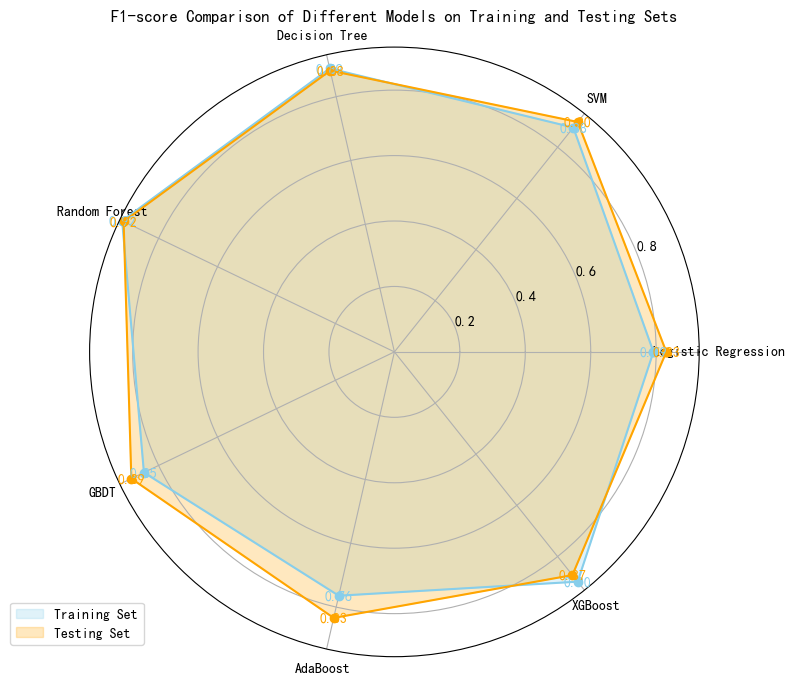

训练集和测试集的 F1-score 雷达图已保存到指定路径。


In [46]:
# 获取模型名称和对应的 F1 值-雷达图
models = list(train_f1_scores.keys())
train_values = list(train_f1_scores.values())
test_values = list(test_f1_scores.values())


angles = np.linspace(0, 2 * np.pi, len(models), endpoint=False).tolist()

train_values += train_values[:1]
test_values += test_values[:1]
angles += angles[:1]


fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))


ax.fill(angles, train_values, alpha=0.25, label='Training Set', color='skyblue')
ax.plot(angles, train_values, marker='o', color='skyblue')


ax.fill(angles, test_values, alpha=0.25, label='Testing Set', color='orange')
ax.plot(angles, test_values, marker='o', color='orange')


for i, (train_val, test_val) in enumerate(zip(train_values[:-1], test_values[:-1])):
    ax.text(angles[i], train_val, f'{train_val:.2f}', ha='center', va='center', color='skyblue')
    ax.text(angles[i], test_val, f'{test_val:.2f}', ha='center', va='center', color='orange')


ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=10)
ax.set_title('F1-score Comparison of Different Models on Training and Testing Sets')


plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()


#save_path = os.path.join(save_dir, 'combined_f1_score_radar_chart.png')
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print("训练集和测试集的 F1-score 雷达图已保存到指定路径。")

<Figure size 1200x800 with 0 Axes>

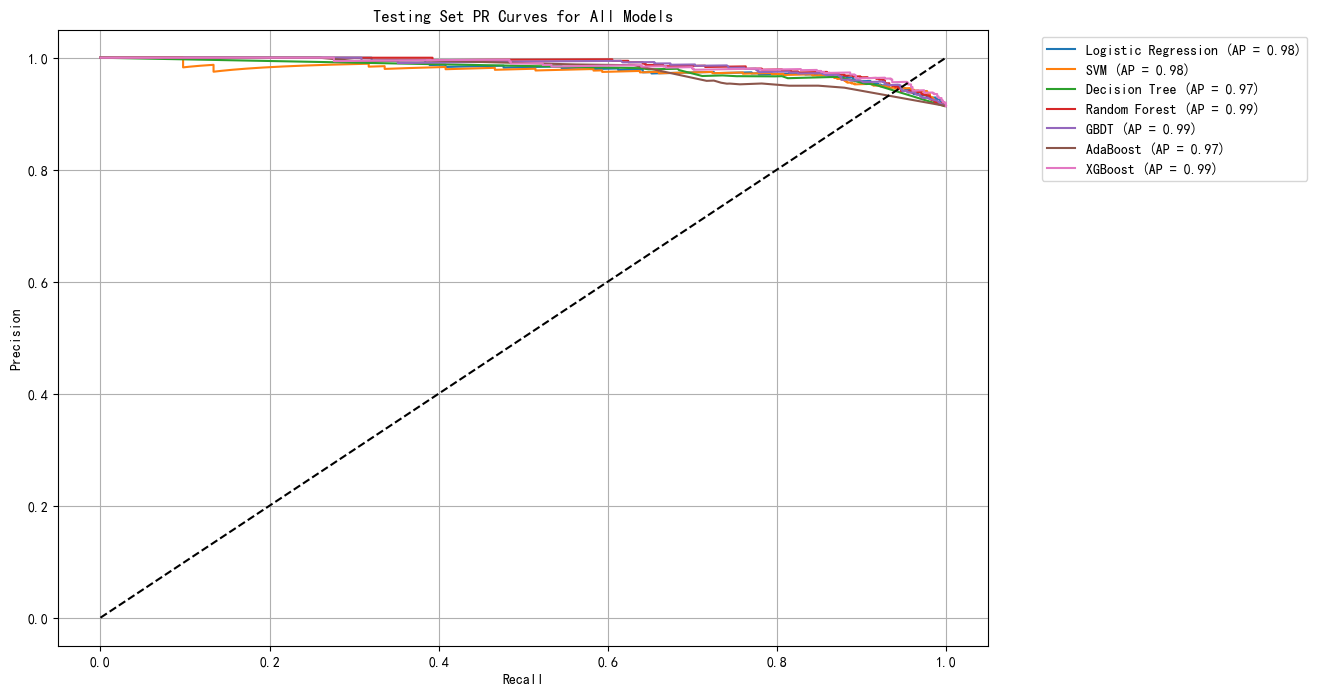

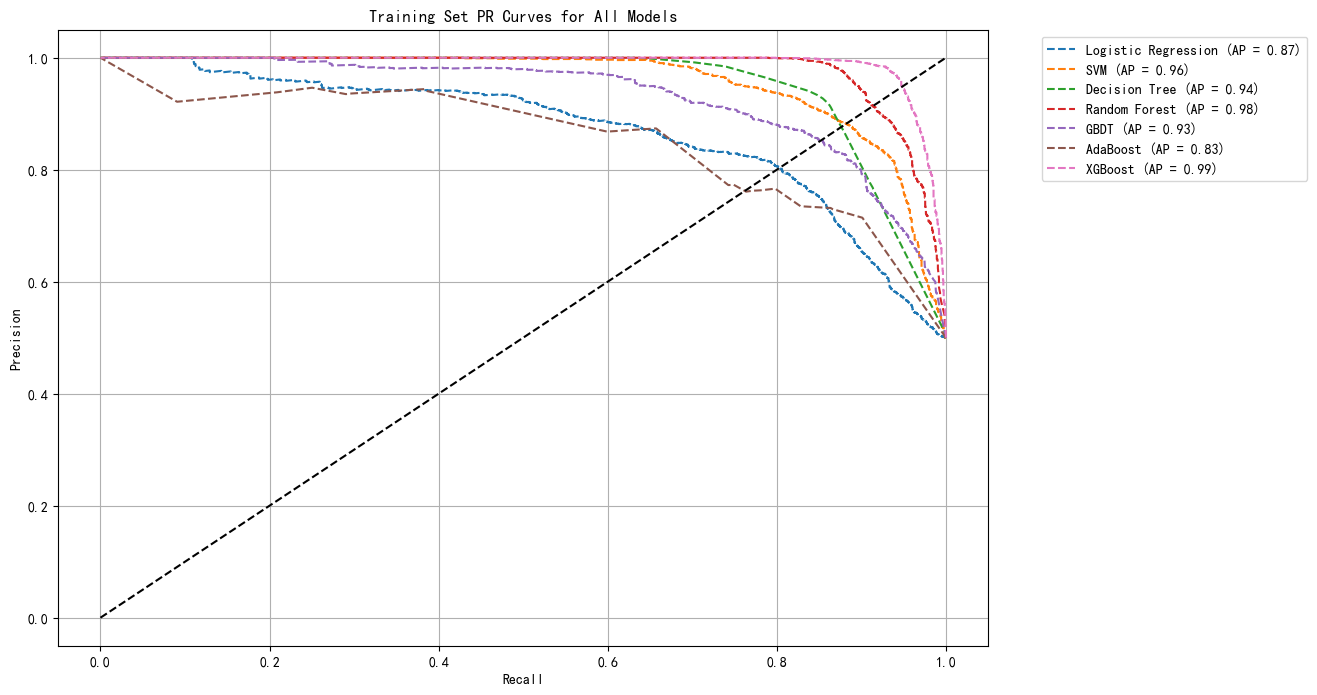

<Figure size 640x480 with 0 Axes>

In [48]:
#绘制PR曲线
save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\pr_curves'
os.makedirs(save_dir, exist_ok=True)


plt.figure(figsize=(12, 8))
train_fig = plt.figure(figsize=(12, 8))
test_fig = plt.figure(figsize=(12, 8))

models = {
    "Logistic Regression": LR_model,
    "SVM": SVM_model,
    "Decision Tree": dt_model,
    "Random Forest": RF,
    "GBDT": gb_model,
    "AdaBoost": adaboost,
    "XGBoost": XGB_model
}

for name, model in models.items():
    train_proba = model.predict_proba(X_train_balanced)[:, 1]
    train_precision, train_recall, _ = precision_recall_curve(y_train_balanced, train_proba)
    train_ap = average_precision_score(y_train_balanced, train_proba)
    
    
    test_proba = model.predict_proba(X_test)[:, 1]
    test_precision, test_recall, _ = precision_recall_curve(y_test, test_proba)
    test_ap = average_precision_score(y_test, test_proba)
    
    
    plt.figure(train_fig.number)
    plt.plot(train_recall, train_precision, linestyle='--', label=f'{name} (AP = {train_ap:.2f})')
    
    
    plt.figure(test_fig.number)
    plt.plot(test_recall, test_precision, label=f'{name} (AP = {test_ap:.2f})')
    

for fig in [train_fig, test_fig]:
    plt.figure(fig.number)
    plt.plot([0, 1], [0, 1], 'k--')

plt.figure(train_fig.number)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Training Set PR Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.figure(test_fig.number)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Testing Set PR Curves for All Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 保存图片
#train_save_path = os.path.join(save_dir, 'training_set_pr_curves.png')
#test_save_path = os.path.join(save_dir, 'testing_set_pr_curves.png')
#plt.figure(train_fig.number)
#plt.savefig(train_save_path, dpi=300, bbox_inches='tight')
#plt.figure(test_fig.number)
#plt.savefig(test_save_path, dpi=300, bbox_inches='tight')


plt.figure(train_fig.number)
plt.show()

plt.figure(test_fig.number)
plt.show()

模型优化

In [49]:
# XGBoost model 7

# 计算正负样本比例
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost基础参数
params_xgb = {
    'learning_rate': 0.01,
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'verbosity': 1,
    'seed': 42,
    'nthread': -1,
    'colsample_bytree': 0.5,
    'subsample': 0.6,
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,  # 动态计算的值
    'gamma': 0.1,
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'early_stopping_rounds': 50  # 关键修正：移入初始化参数
}

# 参数网格
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.5, 0.7]
}

# 创建支持早停的搜索器
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(**params_xgb),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 正确使用验证集（需确保数据分割安全）
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

grid_search.fit(
    X_train_full,
    y_train_full,
    eval_set=[(X_val, y_val)],  # 使用中间验证集
    verbose=False
)

# 最终评估
XGB_model = grid_search.best_estimator_
y_proba_xgb = XGB_model.predict_proba(X_test)[:, 1]

print(f"\nTest AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print("\nClassification Report:\n", classification_report(y_test, XGB_model.predict(X_test)))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Test AUC: 0.8866

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.82      0.37        55
           1       0.98      0.76      0.85       583

    accuracy                           0.76       638
   macro avg       0.61      0.79      0.61       638
weighted avg       0.91      0.76      0.81       638



In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 综合评估报告
def comprehensive_evaluation(model, X_test, y_test, threshold=0.5):
    # 概率预测与阈值调整
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # 核心指标计算
    print("="*40)
    print(f"【综合评估报告】阈值={threshold:.2f}")
    print("="*40)
    print(f"Best Parameters: {model.get_params()}\n")
    
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"G-Mean: {np.sqrt(recall_score(y_test, y_pred) * precision_score(y_test, y_pred)):.4f}\n")
    
    # 详细分类报告
    print("【分类报告】")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
    
    # 多图联合展示
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. ROC曲线（带最佳阈值标记）
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0,0], name='XGBoost')
    axes[0,0].set_title(f'ROC Curve (AUC={roc_auc_score(y_test, y_proba):.2f})')
    axes[0,0].plot([0, 1], [0, 1], 'k--')
    
    # 2. PR曲线
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[0,1])
    axes[0,1].set_title(f'Precision-Recall Curve (AP={average_precision_score(y_test, y_proba):.2f})')
    
    # 3. 混淆矩阵（标准化显示）
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                                       display_labels=['Class 0', 'Class 1'],
                                       normalize='true', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('Normalized Confusion Matrix')
    
    # 4. 特征重要性（前20个）
    feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
    feat_importances.nlargest(20).sort_values().plot(kind='barh', ax=axes[1,1])
    axes[1,1].set_title('Top 20 Feature Importances')
    
    plt.tight_layout()
    plt.show()
    
    # 阈值分析
    optimal_threshold = find_optimal_threshold(y_test, y_proba)
    print(f"\n建议最佳阈值: {optimal_threshold:.3f} (基于Youden指数)")

# 调用评估函数
comprehensive_evaluation(XGB_model, X_test, y_test)

In [ ]:
# 计算 SHAP 值
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_test)

# 绘制 SHAP 总结图
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# 绘制特征重要性
plt.figure(figsize=(10, 6))
#xgb.plot_importance(XGB_model)
plt.title('XGBoost Model Feature Importance')
plt.show()

In [ ]:
# SHAP特征重要性分析
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

最重要特征：

年龄是模型中最重要的特征，平均 SHAP 值高达 1.4，表示其对模型预测结果的影响最大。
GLU（血糖）、ALT 和 AST 也具有较高的重要性，SHAP 值分别在 0.5 到 1.0 之间，显示出这些生化指标在模型预测中的关键作用。
中等影响特征：

UREA 和 UA（尿酸） 的平均 SHAP 值在 0.4 到 0.5 左右，尽管不及前面的一些特征，但仍对模型输出产生显著影响。
IBIL（间接胆红素） 和 BUN/Scr（尿素氮/肌酐比） 的影响相对较小，但仍在一定程度上重要。
较低的重要性特征：

CREA（肌酐）、DBIL（直接胆红素）、性别和 TBIL（总胆红素） 在模型中的影响力相对较小，其平均 SHAP 值均低于 0.2。这表示这些特征在模型预测中贡献有限，尤其是 性别 和 TBIL 的影响很微弱。
模型解读：

该图表提供了对模型输出的直观理解，指出了哪些特征在预测中更为重要，可以作为进一步分析和特征选择的基础。
总体而言，这张图表强调了年龄、血糖、肝功能指标等在模型预测中的主要作用，同时也指出了一些特征的相对不重要性。

In [ ]:
# 保存模型
#joblib.dump(XGB_model , 'XGBoost2.pkl')

In [ ]:
# 使用 xgboost 原生方法绘制特征重要性图
xgb.plot_importance(XGB_model)
plt.title("xgboost.plot_importance(model)")
plt.show()

从这张图中，我们可以得出关于不同特征对模型的重要性排名的结论。每个特征的 F score 值表示它们对模型的贡献程度。以下是一些关键点：

最重要的特征：UA（尿酸）的 F score 值最高，达到 1184，说明它在模型预测中起到了最关键的作用。

次重要的特征：ALT 和 AST 分别排在第二和第三，F score 值为 1089 和 1062。这表明肝功能相关的指标在模型中同样是重要的预测因素。

其他重要特征：BUN/Scr、年龄、GLU（血糖）、CREA（肌酐）和 UREA（尿素）的 F score 值稍低，但仍然表明它们对模型的预测性能有显著贡献。

相对较不重要的特征：性别的 F score 值最低，仅为 137，显示其对模型影响较小。

In [ ]:
#绘制SPAP摘要图
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance (Beeswarm)")
plt.tight_layout()
plt.show()

特征的重要性：

确定 UA（尿酸）在模型预测中是最重要的特征，因其大多数 SHAP 值集中在约 2 到 3 之间，说明高尿酸水平对模型输出有显著影响。
其次是 ALT 和 AST，这两个肝功能指标也表现出了较强的正面影响，SHAP 值在 1 到 2 之间。
负面影响特征：

年龄、GLU（血糖）、UREA（尿素）和其他一些特征（如 BUN/Scr、CREA、DBIL）表现出相对较分散的 SHAP 值，表明这些特征对模型输出的影响较小，并且对不同样本的影响也是双向的（有正效应也有负效应）。
性别和 TBIL（总胆红素）的影响：

性别的 SHAP 值并没有明显的集中趋势，表明在这个模型中，性别对预测结果的影响非常有限。
TBIL 也表现出较小且分散的影响，说明它对模型的贡献不大。
SHAP 值的分布：

图中颜色范围从蓝色到红色，蓝色表示特征值低，红色表示特征值高。可以看到，大部分重要特征（如 UA、ALT 和 AST）与更高的正效果相关联，而那些效果较弱的特征（如性别和 TBIL）显示了较小的影响范围。

In [ ]:
# 解释单个样本预测（示例）
sample_idx = 0
shap.force_plot(explainer.expected_value, 
               shap_values[sample_idx,:], 
               X_test.iloc[sample_idx,:], 
               matplotlib=True)



In [ ]:
# 评估
print("Best Parameters:", grid_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_test, y_proba_xgb))
ap = average_precision_score(y_test, y_proba_xgb)
print("Average Precision:", ap)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

f1 = f1_score(y_test, y_pred_xgb)
print("XGBoost  F1 - score:", f1)


fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba_xgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Model ROC Curve')
plt.legend()
plt.show()


# PR曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
ap = average_precision_score(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(' XGBoost Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Model Confusion Matrix')
plt.show()



从这张 SHAP 值图中，可以得出以下结论：

基线值：

图中标注了一个基线值为 0，指的是模型预测的基础期望值。该图显示了不同特征如何影响最终的预测结果。
特征影响：

UA（尿酸） 的值为 186.0，并且对最终输出的影响非常显著，是所有特征中对模型输出贡献最大的，且其影响是正向的。
CREA（肌酐） 和 AST（天冬氨酸氨基转移酶） 也对预测结果产生一定的正向影响，分别贡献了 52.4 和 16.0。
BUN/Scr（尿素氮与肌酐比） 的影响较小，为 19.0，但仍对模型结果起到了促进作用。
较小的影响：

年龄（84.83） 和 ALT（丙氨酸氨基转移酶）（8.0） 在模型中的影响也为正向，但相对较小。
GLU（血糖） 的值（4.33）对预测结果的影响是负向的，其影响相对较小，说明在该个体的情况下，血糖水平对模型的综合评分起到了略微降低的作用。
最终预测：

最终模型的预测输出值为 7.63，远高于基线值 0，说明整体上通过这些指标，该个体的健康状况的预测是偏向于较为正常或健康的。
总体来看，这张图清晰地展示了各个特征对模型预测结果的正负影响及其相对重要性

In [ ]:
# PR曲线
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
ap = average_precision_score(y_test, y_proba_xgb)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(' XGBoost Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


这张精确率-召回率曲线图中，可以得出以下结论：

总体表现优异：AP（平均精确率）值为 0.99，表明模型在处理该任务时的表现极为优秀。这表示在不同的召回率水平下，模型的精确率基本保持在 0.99 以上。

高精确率与高召回率：从图中可以看出，当召回率低于 0.4 时，精确率几乎保持在 1.0。即使在高召回率的情况下，精确率仍然相对较高，虽然逐渐呈现下降趋势。这表明模型在大多数情况下能够有效识别正样本，同时保持低假阳性率。

逐步下降的趋势：随着召回率的增加，精确率开始有所下降，这表明在极高的召回率下，模型可能会引入一些假阳性。这是一个常见的现象，尤其是在处理不平衡数据集时。

平衡性考虑：虽然模型在高召回率下表现良好，仍需考虑在实际应用中如何在精确率和召回率之间取得最佳平衡，根据具体的应用场景（如医疗诊断、欺诈检测）选择合适的阈值。

总体而言，该模型在各种条件下展现出卓越的精确率，具有良好的实用价值。

In [ ]:
# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

从这个混淆矩阵中，可以得出以下结论：

数据分布：

总体样本数：25 + 30 + 33 + 550 = 638
预测为类别 0 的实际数量（实际上为 0 的样本）：25 + 30 = 55
预测为类别 1 的实际数量（实际上为 1 的样本）：33 + 550 = 583
预测准确性：

真阳性 (TP)：550（实际为 1，预测也为 1）
真阴性 (TN)：25（实际为 0，预测也为 0）
假阳性 (FP)：30（实际为 0，但预测为 1）
假阴性 (FN)：33（实际为 1，但预测为 0）

假阴性和假阳性分析：

假阴性（33个样本，即模型将实际为 1 的样本预测为 0）相对较低，说明模型在识别正样本方面的能力较强，但假阳性（30个样本，即模型将实际为 0 的样本预测为 1）也表明模型有时会错误地将负样本归为正样本。
总体来看，模型在大多数情况下表现良好，准确性、精确率和召回率都很高。不过，仍需注意假阳性和假阴性的问题，特别是在某些场合下，假阴性可能会导致漏掉重要的正样本。

上述两张图对比了多个机器学习模型（逻辑回归、支持向量机、决策树、随机森林、GBDT、AdaBoost、XGBoost）的 ROC 曲线，分别展示了它们在训练集（AUC最高的是GBDT和XGBoost，均为0.98）和测试集上的表现（AUC最高的是随机森林和XGBoost，均为0.88；逻辑回归最低，为0.74）。ROC曲线以真正率（TPR）为y轴，假正率（FPR）为x轴，AUC值越高代表模型性能越好，区分正负类的能力越强。


In [ ]:
# 忽略警告信息
warnings.filterwarnings("ignore", category=FitFailedWarning)

# 定义学习曲线绘制函数
def plot_learning_curve(model, X, y, cv, train_sizes, scoring, save_dir):
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)
        
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                         val_scores_mean + val_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation score")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.title(f"Learning Curve for {model.__class__.__name__}")
        plt.legend(loc="best")
        plt.grid()
        plt.tight_layout()
       
        
        # 保存图片
        save_dir = 'C:\\Users\\lenovo\\毕设-20212133050\\learning_curves'
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'learning_curve_{model.__class__.__name__}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error occurred while plotting learning curve for {model.__class__.__name__}: {e}")

# 定义交叉验证函数
def plot_cross_validation(models, X, y, cv, scoring, save_dir):
    try:
        plt.figure(figsize=(10, 6))
        for name, model in models.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
            plt.bar(name, np.mean(scores), yerr=np.std(scores), align='center', alpha=0.8)
        
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.title('Cross Validation Scores')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        
        # 保存图片
        #save_path = os.path.join(save_dir, 'cross_validation_scores.png')
        #plt.savefig(save_path, dpi=300, bbox_inches='tight')
        #plt.show()
    #except Exception as e:
        #print(f"Error occurred while plotting cross validation scores: {e}")

# 设置学习曲线参数
cv = 5  # 交叉验证折数
train_sizes = np.linspace(0.1, 1.0, 5)  # 训练数据量的百分比
scoring = 'f1'  # 评估指标


# 为每个模型绘制学习曲线
#for name, model in models.items():
    #plot_learning_curve(model, X_train_balanced, y_train_balanced, cv, train_sizes, scoring, save_dir)

# 执行交叉验证并绘制结果
#plot_cross_validation(models, X_train_balanced, y_train_balanced, cv=5, scoring='f1', save_dir=save_dir)



In [ ]:
#交叉验证
from sklearn.model_selection import cross_val_score

# 定义交叉验证函数
def plot_cross_validation(models, X, y, cv, scoring, save_dir):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
        plt.bar(name, np.mean(scores), yerr=np.std(scores), align='center', alpha=0.8)
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Cross Validation Scores')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 执行交叉验证并绘制结果
plot_cross_validation(models, X_train_balanced, y_train_balanced, cv=5, scoring='f1', save_dir=save_dir)